In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import pandas as pd
import scipy.sparse as sp
from openTSNE import TSNE
from tqdm import tqdm
from collections import defaultdict
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score

In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import configuration
import model_registry
import data.construct
import data.constants as dconst
from data.util import data_get_num_attributes, data_get_num_classes, vertex_intersection
import util

In [4]:
data_cfg = configuration.DataConfiguration(
    dataset='cora_full', 
    train_portion=20, test_portion_fixed=0.2,
    split_type='uniform',
    type='npz',
    base_labels = ['Artificial_Intelligence/Machine_Learning/Case-Based', 'Artificial_Intelligence/Machine_Learning/Theory', 'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms', 'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods', 'Artificial_Intelligence/Machine_Learning/Neural_Networks','Artificial_Intelligence/Machine_Learning/Rule_Learning','Artificial_Intelligence/Machine_Learning/Reinforcement_Learning','Operating_Systems/Distributed', 'Operating_Systems/Memory_Management', 'Operating_Systems/Realtime', 'Operating_Systems/Fault_Tolerance'],
    train_labels = ['Artificial_Intelligence/Machine_Learning/Case-Based', 'Artificial_Intelligence/Machine_Learning/Theory', 'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms', 'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods', 'Artificial_Intelligence/Machine_Learning/Neural_Networks','Artificial_Intelligence/Machine_Learning/Rule_Learning','Artificial_Intelligence/Machine_Learning/Reinforcement_Learning'],
    left_out_class_labels = ['Operating_Systems/Distributed', 'Operating_Systems/Memory_Management', 'Operating_Systems/Realtime', 'Operating_Systems/Fault_Tolerance'],
    corpus_labels = ['Artificial_Intelligence/Machine_Learning/Case-Based', 'Artificial_Intelligence/Machine_Learning/Theory', 'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms', 'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods', 'Artificial_Intelligence/Machine_Learning/Neural_Networks','Artificial_Intelligence/Machine_Learning/Rule_Learning','Artificial_Intelligence/Machine_Learning/Reinforcement_Learning'],
    preprocessing='bag_of_words',
    ood_type = dconst.LEFT_OUT_CLASSES,
    # ood_type = dconstants.PERTURBATION,
    setting = dconst.HYBRID,
    #preprocessing='word_embedding',
    #language_model = 'bert-base-uncased',
    #language_model = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
    #language_model = 'allenai/longformer-base-4096',
    drop_train_vertices_portion = 0.1,
    ood_sampling_strategy = dconst.SAMPLE_ALL,
    )

In [5]:
data_list, fixed_vertices = data.construct.load_data_from_configuration(data_cfg, 1)

In [6]:
idx_train = []
from copy import copy
_vertex_to_idx_train = copy(data_list[0][dconst.TRAIN][0].vertex_to_idx)
_idx_to_vertex_train = util.invert_mapping(_vertex_to_idx_train)
_vertex_to_idx_ood_val = copy(data_list[0][dconst.OOD_VAL][0].vertex_to_idx)
_mask_train = data_list[0][dconst.TRAIN][0].mask.numpy()

for idx in np.where(_mask_train)[0].tolist():
    idx_train.append(_vertex_to_idx_ood_val[_idx_to_vertex_train[idx]])

In [15]:
X = data_list[0][dconst.OOD_VAL][0].x.numpy()
N = X.shape[0]
edge_index = data_list[0][dconst.OOD_VAL][0].edge_index.numpy()
A = sp.coo_matrix((np.ones(edge_index.shape[1]), edge_index), shape=(N, N))
# Normalize adjacency
# A += sp.coo_matrix(np.eye(A.shape[0]))
degrees = A.sum(axis=0)[0].tolist()
D = sp.diags(degrees, [0])
D = D.power(-0.5)
A = D.dot(A).dot(D)

A_dense = A.todense()
y = data_list[0][dconst.OOD_VAL][0].y.numpy()
idx_to_label = util.invert_mapping(data_list[0][dconst.OOD_VAL][0].label_to_idx)
is_ood = data_list[0][dconst.OOD_VAL][0].is_out_of_distribution.numpy()

is_train = np.zeros_like(is_ood, dtype=bool)
is_train[idx_train] = True

ood_val_mask = data_list[0][dconst.OOD_VAL][0].mask.numpy()

In [8]:
A_powers = [A]
for k in tqdm(range(4)):
    A_powers.append(A_powers[-1] @ A)

100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


In [9]:
A_powers = {idx + 1 : A_p.todense() for idx, A_p in enumerate(A_powers)}

In [10]:
def approximate_personalized_pagerank(A, alpha=0.2, n_iter=10):
    n = A.shape[0]
    A = A.tocsr()
    ppr = np.ones((n, n)) / n
    for _ in tqdm(range(n_iter), desc='Approximate Page Rank'):
        ppr = (alpha * np.eye(n)) + ((1 - alpha) * (A @ ppr))
    return ppr

In [11]:
for k in (2, 10, 16):
    A_powers[f'APPR-{k}'] = approximate_personalized_pagerank(A, n_iter=k)
    A_powers[f'APPR-{k}@X'] = A_powers[f'APPR-{k}'] @ X

Approximate Page Rank: 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


In [12]:
A_powers['X'] = X

In [16]:
label_prop = A_powers['APPR-16'] @ is_train.astype(float)
roc_auc_score((~is_ood).astype(int)[ood_val_mask], label_prop[ood_val_mask])

0.9242772298131514

In [14]:
is_train.sum()

140

In [49]:
embs = {}
for k, A_p in A_powers.items():
    print(f'{k}...')
    if '@X' in str(k) or 'X' in str(k):
        tsne_kwargs = {}
    else:
        tsne_kwargs = {'metric' : 'precomputed', 'initialization' : 'spectral'}
    # Fit to all
    tsne_all = TSNE(verbose=1, **tsne_kwargs, n_jobs=8)
    emb_all = tsne_all.fit(A_p)
    embs[(k, 'all')] = np.array(emb_all)
    
    if tsne_kwargs.get('metric', None) != 'precomputed':
        # Fit to id only, transform ood
        tsne_id = TSNE(verbose=1, n_jobs=8, **tsne_kwargs)
        emb_id = tsne_id.fit(A_p[~is_ood])
        embs[(k, 'id-only')] = emb_id.transform(A_p)



1...
--------------------------------------------------------------------------------
TSNE(initialization='spectral', metric='precomputed', n_jobs=8, verbose=1)
--------------------------------------------------------------------------------
===> Calculating affinity matrix...
   --> Time elapsed: 0.22 seconds
===> Calculating spectral initialization...
   --> Time elapsed: 0.07 seconds
===> Running optimization with exaggeration=12.00, lr=379.42 for 250 iterations...
Iteration   50, KL divergence 4.1999, 50 iterations in 0.5351 sec
Iteration  100, KL divergence 4.3140, 50 iterations in 0.5351 sec
Iteration  150, KL divergence 4.5073, 50 iterations in 0.5136 sec
Iteration  200, KL divergence 4.1807, 50 iterations in 0.4745 sec
Iteration  250, KL divergence 4.1734, 50 iterations in 0.4817 sec
   --> Time elapsed: 2.54 seconds
===> Running optimization with exaggeration=1.00, lr=379.42 for 500 iterations...
Iteration   50, KL divergence 2.0146, 50 iterations in 0.4080 sec
Iteration  100,

===> Calculating affinity matrix...
   --> Time elapsed: 0.10 seconds
===> Calculating spectral initialization...
   --> Time elapsed: 0.09 seconds
===> Running optimization with exaggeration=12.00, lr=379.42 for 250 iterations...
Iteration   50, KL divergence 4.4136, 50 iterations in 0.5249 sec
Iteration  100, KL divergence 4.4623, 50 iterations in 0.5520 sec
Iteration  150, KL divergence 4.1728, 50 iterations in 0.5699 sec
Iteration  200, KL divergence 4.4677, 50 iterations in 0.5391 sec
Iteration  250, KL divergence 4.1038, 50 iterations in 0.5273 sec
   --> Time elapsed: 2.71 seconds
===> Running optimization with exaggeration=1.00, lr=379.42 for 500 iterations...
Iteration   50, KL divergence 1.9622, 50 iterations in 0.4287 sec
Iteration  100, KL divergence 5.8448, 50 iterations in 0.3884 sec
Iteration  150, KL divergence 3.4597, 50 iterations in 0.3824 sec
Iteration  200, KL divergence 3.3972, 50 iterations in 0.3907 sec
Iteration  250, KL divergence 3.1882, 50 iterations in 0.38

Iteration  100, KL divergence 2.1908, 50 iterations in 0.4748 sec
Iteration  150, KL divergence 1.9791, 50 iterations in 0.5164 sec
Iteration  200, KL divergence 1.8487, 50 iterations in 0.5105 sec
Iteration  250, KL divergence 1.7628, 50 iterations in 0.5216 sec
Iteration  300, KL divergence 1.7016, 50 iterations in 0.5257 sec
Iteration  350, KL divergence 1.6562, 50 iterations in 0.5321 sec
Iteration  400, KL divergence 1.6209, 50 iterations in 0.5346 sec
Iteration  450, KL divergence 1.5923, 50 iterations in 0.5910 sec
Iteration  500, KL divergence 1.5703, 50 iterations in 0.5529 sec
   --> Time elapsed: 5.20 seconds
--------------------------------------------------------------------------------
TSNE(n_jobs=8, verbose=1)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 5.38 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 

===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 56507.9242, 50 iterations in 0.3751 sec
Iteration  100, KL divergence 55815.1574, 50 iterations in 0.3916 sec
Iteration  150, KL divergence 55373.1498, 50 iterations in 0.3811 sec
Iteration  200, KL divergence 55035.4999, 50 iterations in 0.3914 sec
Iteration  250, KL divergence 54776.9730, 50 iterations in 0.4856 sec
   --> Time elapsed: 2.03 seconds
X...
--------------------------------------------------------------------------------
TSNE(n_jobs=8, verbose=1)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 9.88 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.08 seconds
===> Calculating PCA-based initial

In [52]:
data = defaultdict(list)
for (k, fit_to), X_p in embs.items():
    
    for labels_name, labels in {
        'Class' : [idx_to_label[i] for i in y],
        'OOD' : ['OOD' if i else 'ID' for i in is_ood],
    }.items():
        data['Label'] += labels
        data['x1'] += X_p[:, 0].tolist()
        data['x2'] += X_p[:, 1].tolist()
        if isinstance(k, int):
            name = f'{k}-hop Neighbourhood'
        elif 'PPR' in k:
            name = k
        elif k == 'X':
            name = k
        else:
            raise ValueError(k)
        data['Method'] += y.shape[0] * [name]
        data['Type'] += y.shape[0] * [labels_name]
        data['Fit to'] += y.shape[0] * [fit_to]
df = pd.DataFrame(data) 


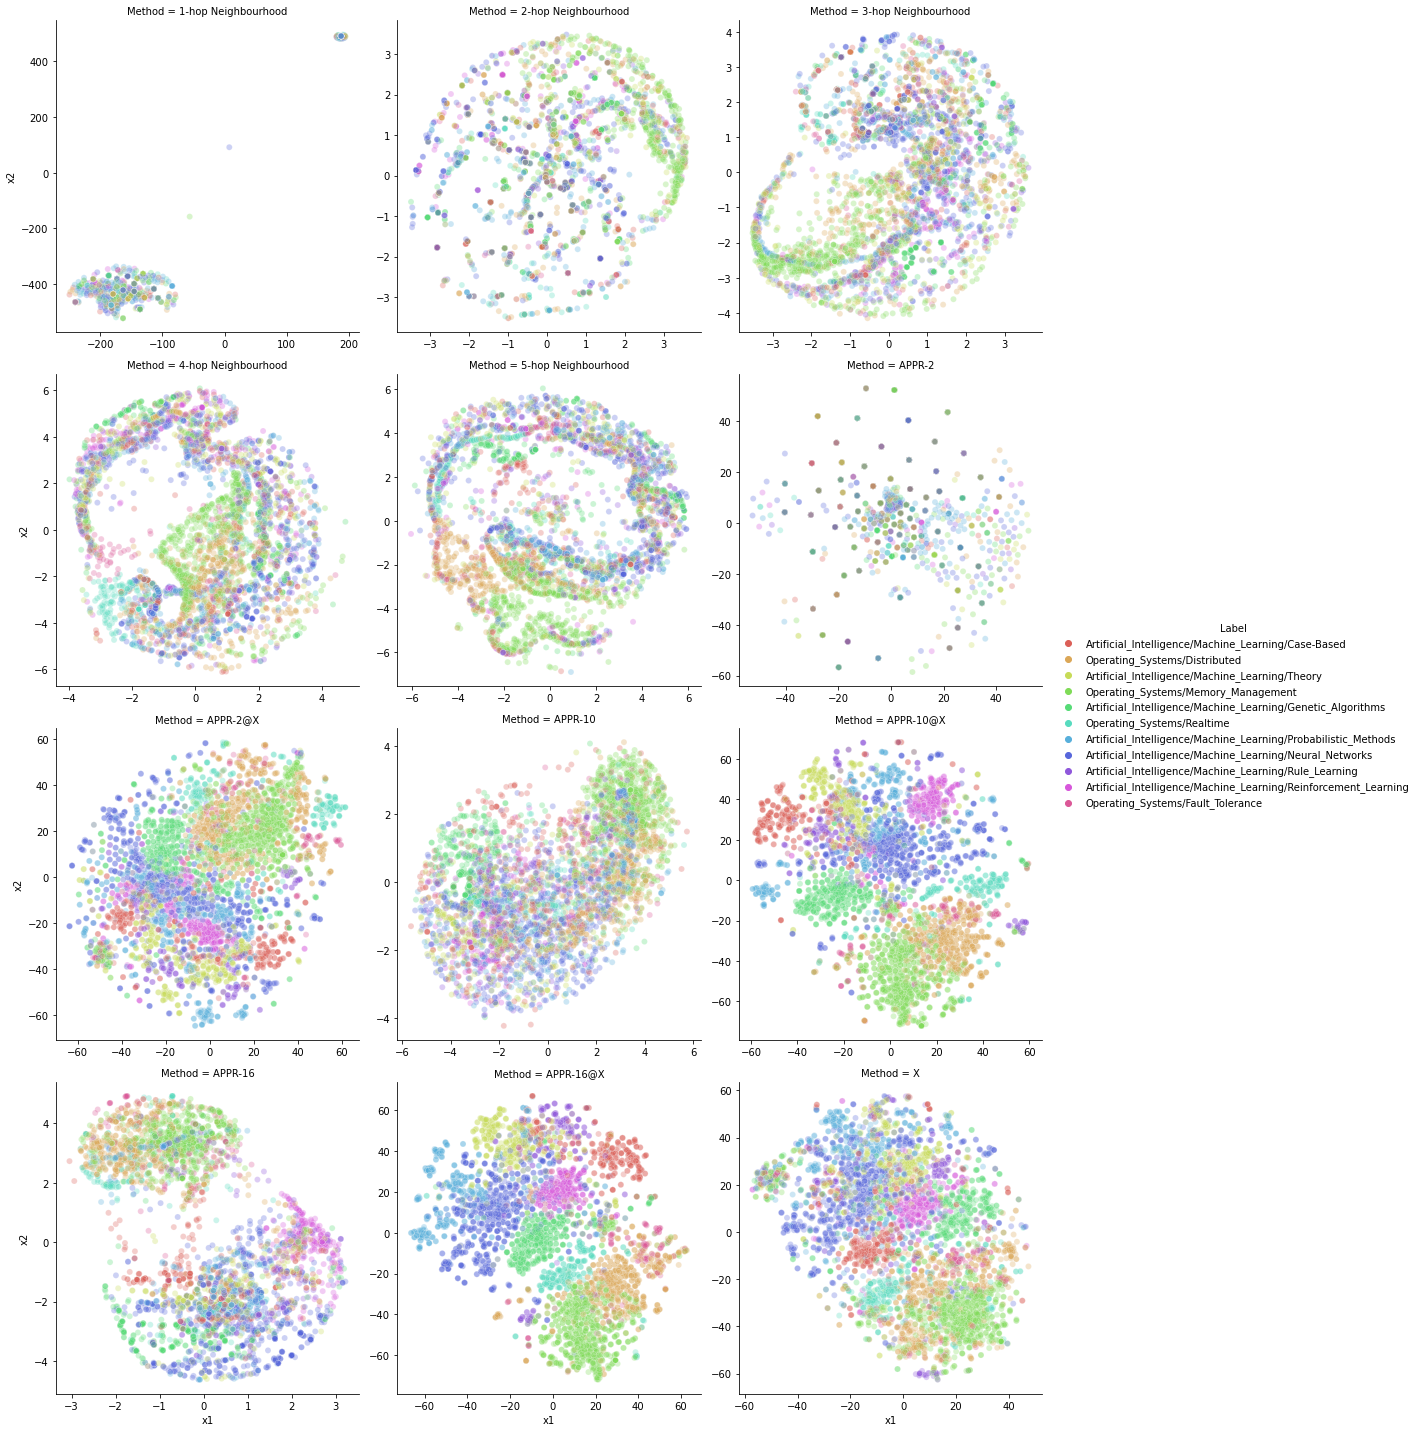

In [56]:
sns.relplot(data = df.query('Type == "Class" and `Fit to` == "all"'), 
            x='x1', y='x2', hue='Label', col='Method', col_wrap=3, alpha=0.3, 
            palette='hls', markers='x', 
            facet_kws={'sharex' : False, 'sharey' : False, 'margin_titles' : True})

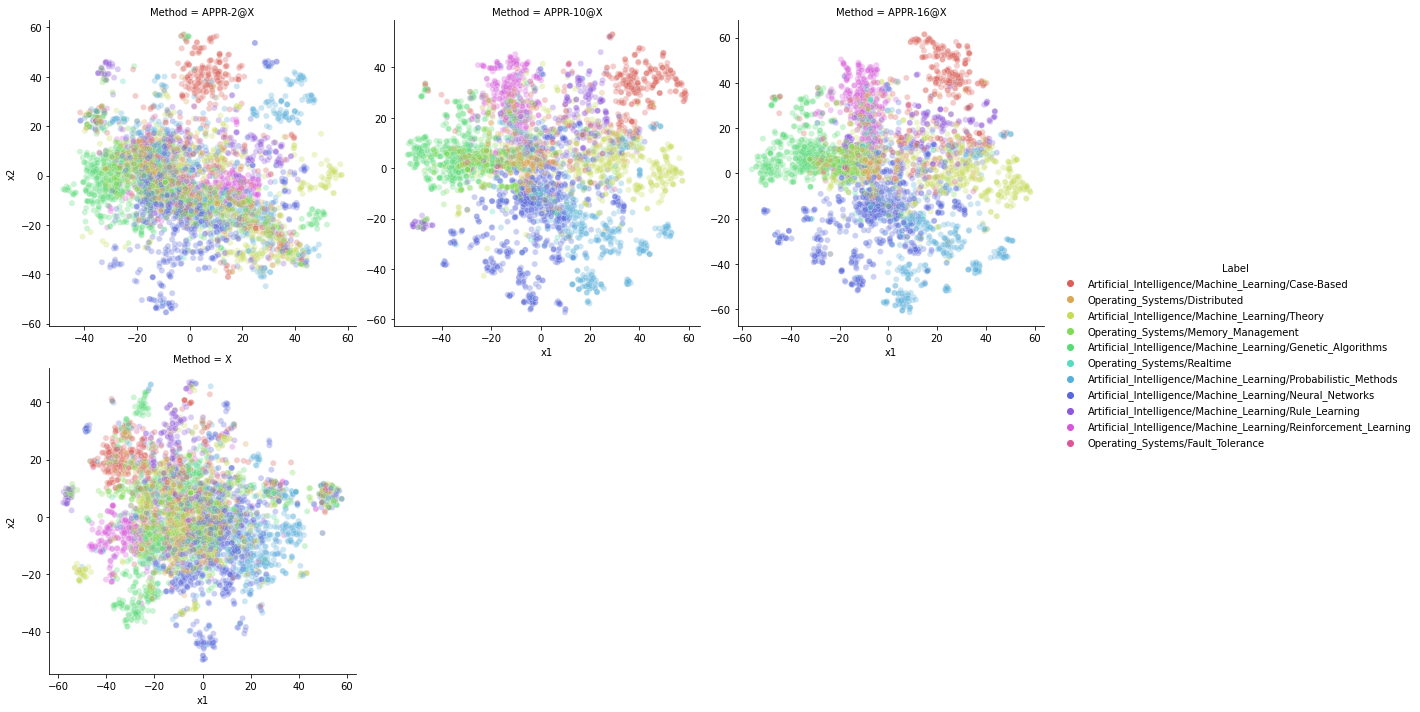

In [57]:
sns.relplot(data = df.query('Type == "Class" and `Fit to` == "id-only"'), 
            x='x1', y='x2', hue='Label', col='Method', col_wrap=3, alpha=0.3, 
            palette='hls', markers='x', 
            facet_kws={'sharex' : False, 'sharey' : False, 'margin_titles' : True})

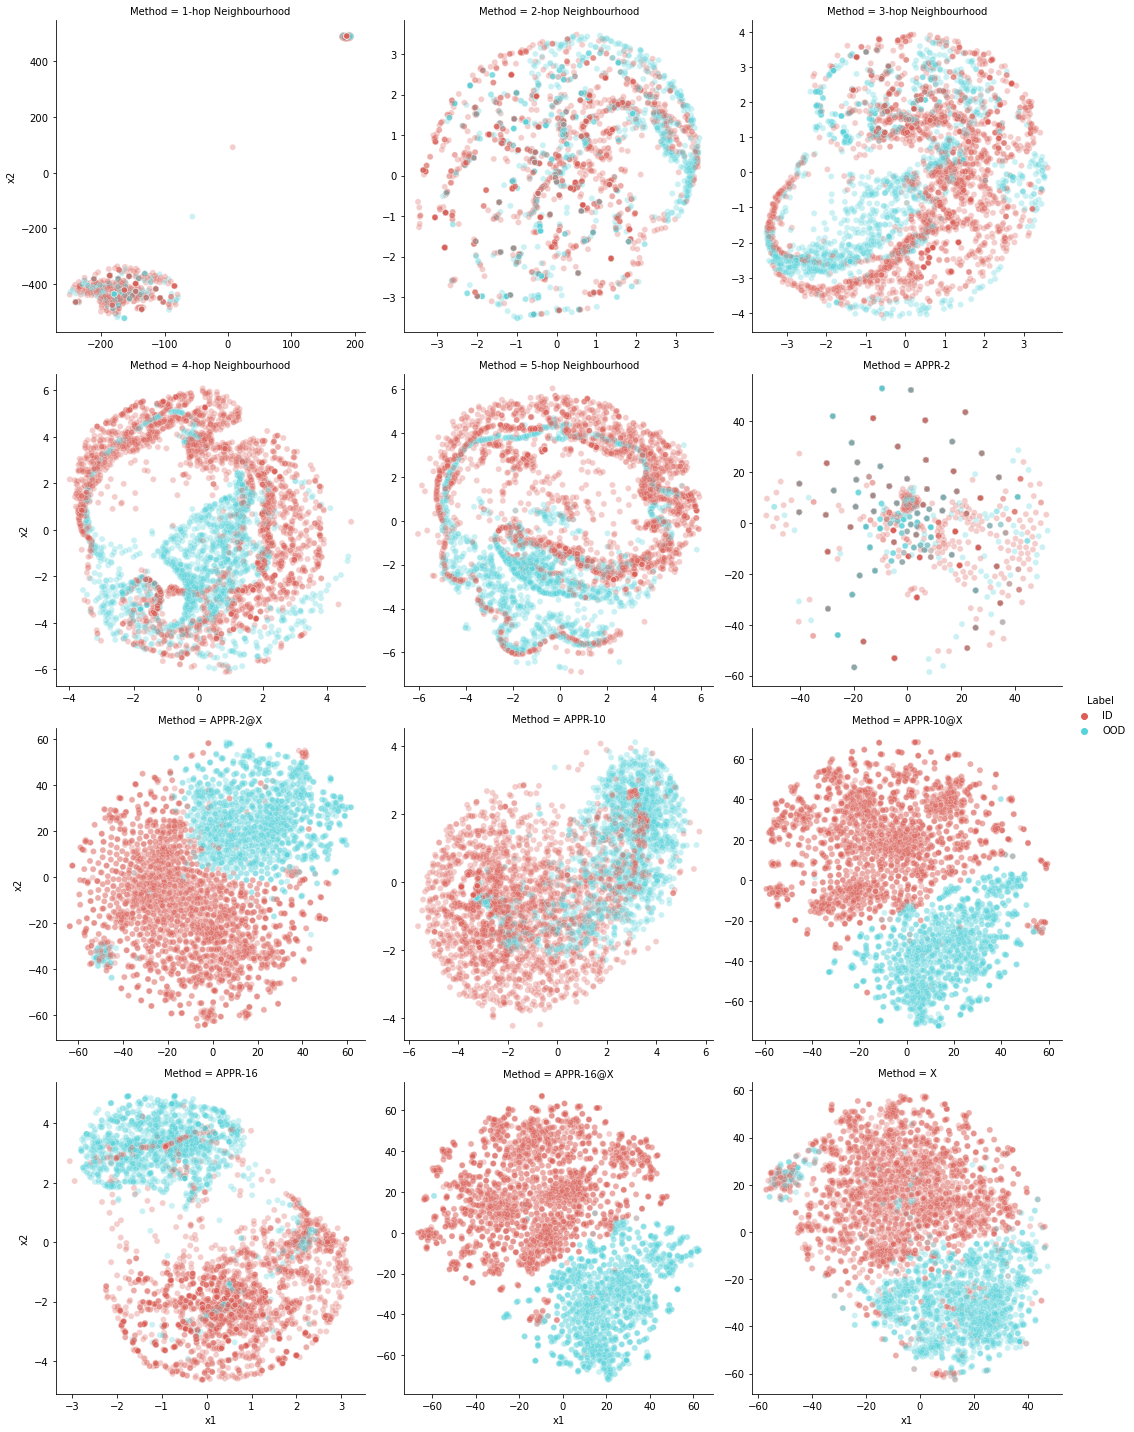

In [60]:
sns.relplot(data = df.query('Type == "OOD" and `Fit to` == "all"'), 
            x='x1', y='x2', hue='Label', col='Method', col_wrap=3, alpha=0.3, 
            palette='hls', markers='x', 
            facet_kws={'sharex' : False, 'sharey' : False, 'margin_titles' : True})

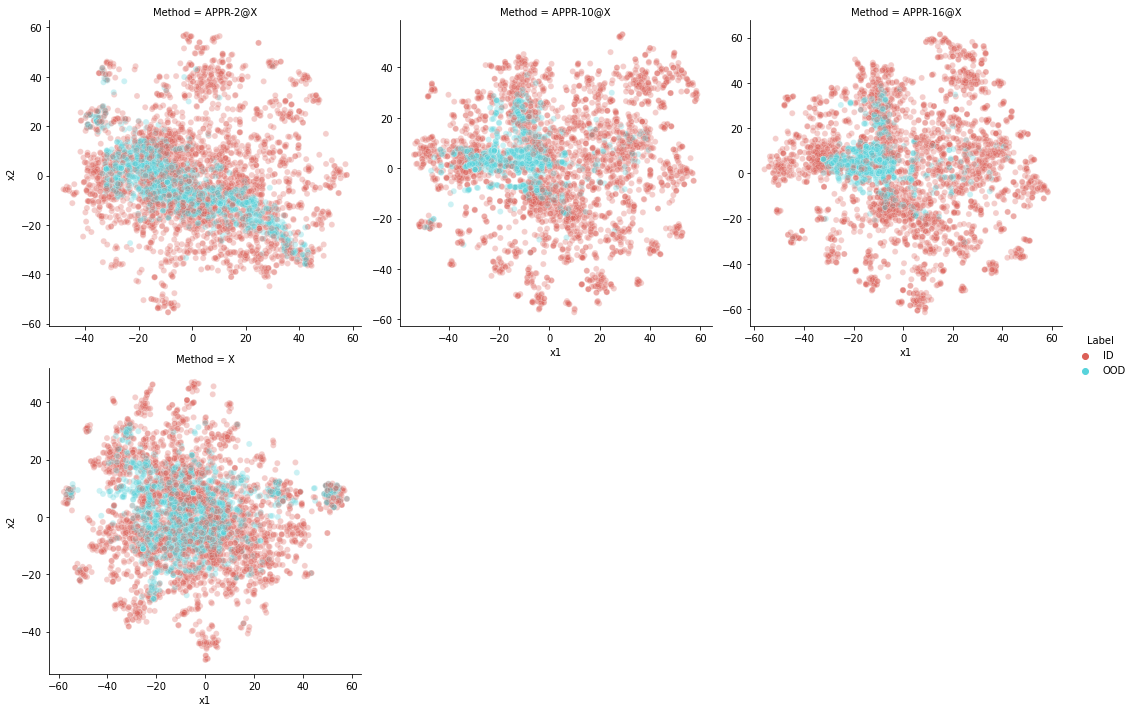

In [59]:
sns.relplot(data = df.query('Type == "OOD" and `Fit to` == "id-only"'), 
            x='x1', y='x2', hue='Label', col='Method', col_wrap=3, alpha=0.3, 
            palette='hls', markers='x', 
            facet_kws={'sharex' : False, 'sharey' : False, 'margin_titles' : True})

In [69]:
# AUROCs of one-class SVM on embs
aurocs = {}
for (k, fit_to), emb in tqdm(embs.items()):
        svm = OneClassSVM(gamma='auto').fit(emb)
        scores = svm.score_samples(emb)
        auroc = roc_auc_score((~is_ood).astype(int), -scores)
        pred = 0.5 * (svm.predict(emb) + 1)
        
        
        aurocs[(k, fit_to)] = auroc
        
        



100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


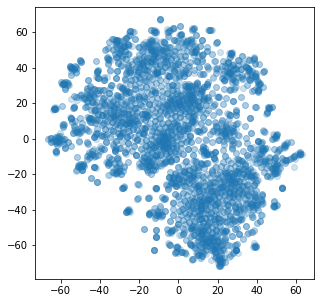

In [82]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(embs[('APPR-16@X', 'all')][:, 0], embs[('APPR-16@X', 'all')][:, 1], alpha=0.2)

In [76]:
print(pd.DataFrame([{'Method' : m, 'Fit to' : fit_to, 'AUROC': value} for (m, fit_to), value in aurocs.items()]).to_markdown())

|    | Method    | Fit to   |    AUROC |
|---:|:----------|:---------|---------:|
|  0 | 1         | all      | 0.454468 |
|  1 | 2         | all      | 0.44672  |
|  2 | 3         | all      | 0.465547 |
|  3 | 4         | all      | 0.502386 |
|  4 | 5         | all      | 0.591565 |
|  5 | APPR-2    | all      | 0.453837 |
|  6 | APPR-2@X  | all      | 0.507731 |
|  7 | APPR-2@X  | id-only  | 0.724478 |
|  8 | APPR-10   | all      | 0.551185 |
|  9 | APPR-10@X | all      | 0.502179 |
| 10 | APPR-10@X | id-only  | 0.760115 |
| 11 | APPR-16   | all      | 0.581218 |
| 12 | APPR-16@X | all      | 0.50774  |
| 13 | APPR-16@X | id-only  | 0.770896 |
| 14 | X         | all      | 0.494282 |
| 15 | X         | id-only  | 0.664144 |


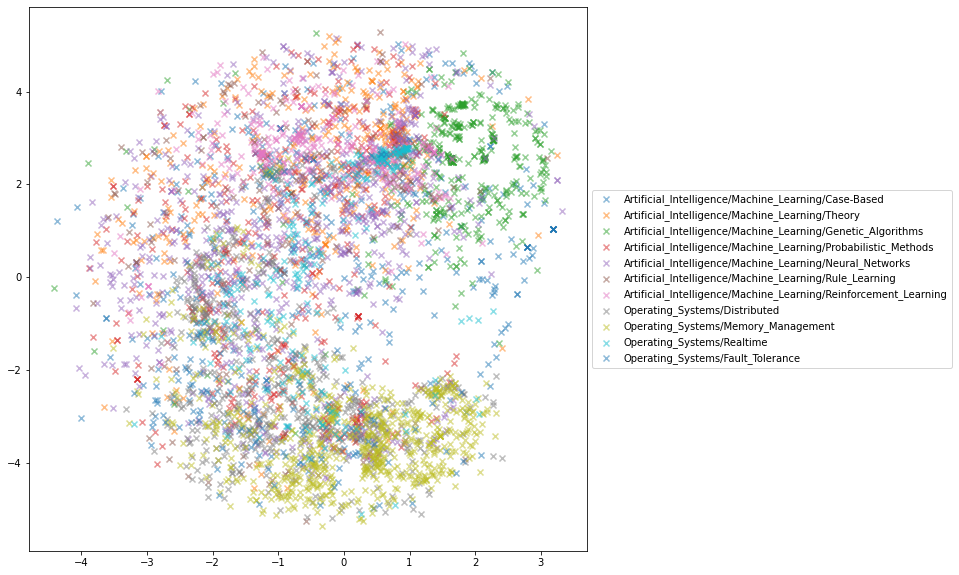

In [68]:
fix, ax = plt.subplots(figsize=(10, 10))
for idx, label in idx_to_label.items():
    
    ax.scatter(structure_emb[y == idx][:, 0], structure_emb[y == idx][:, 1], label=label, alpha=0.5, marker='x')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

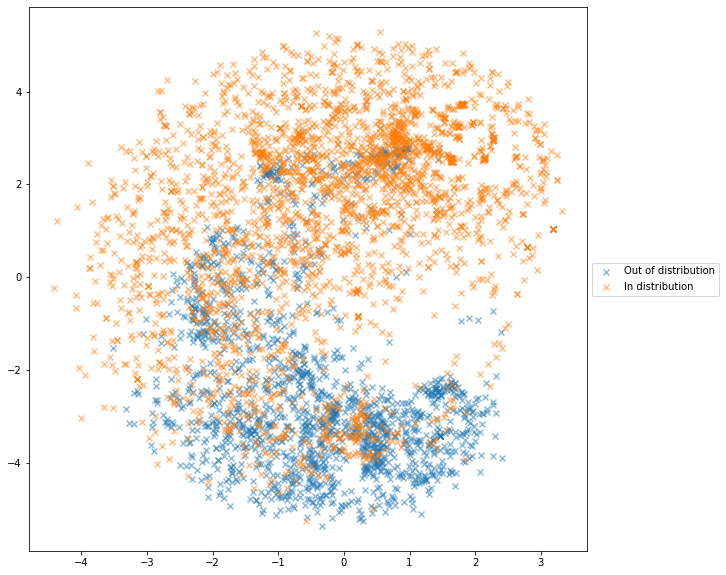

In [70]:
fix, ax = plt.subplots(figsize=(10, 10))
    
ax.scatter(structure_emb[is_ood][:, 0], structure_emb[is_ood][:, 1], label='Out of distribution', alpha=0.5, marker='x')
ax.scatter(structure_emb[~is_ood][:, 0], structure_emb[~is_ood][:, 1], label='In distribution', alpha=0.5, marker='x')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [30]:
tsne_features = TSNE(verbose=1,)
feature_emb = tsne_features.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4553 samples in 0.022s...
[t-SNE] Computed neighbors for 4553 samples in 5.402s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4553
[t-SNE] Computed conditional probabilities for sample 2000 / 4553
[t-SNE] Computed conditional probabilities for sample 3000 / 4553
[t-SNE] Computed conditional probabilities for sample 4000 / 4553
[t-SNE] Computed conditional probabilities for sample 4553 / 4553
[t-SNE] Mean sigma: 0.274803
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.713875
[t-SNE] KL divergence after 1000 iterations: 2.193747


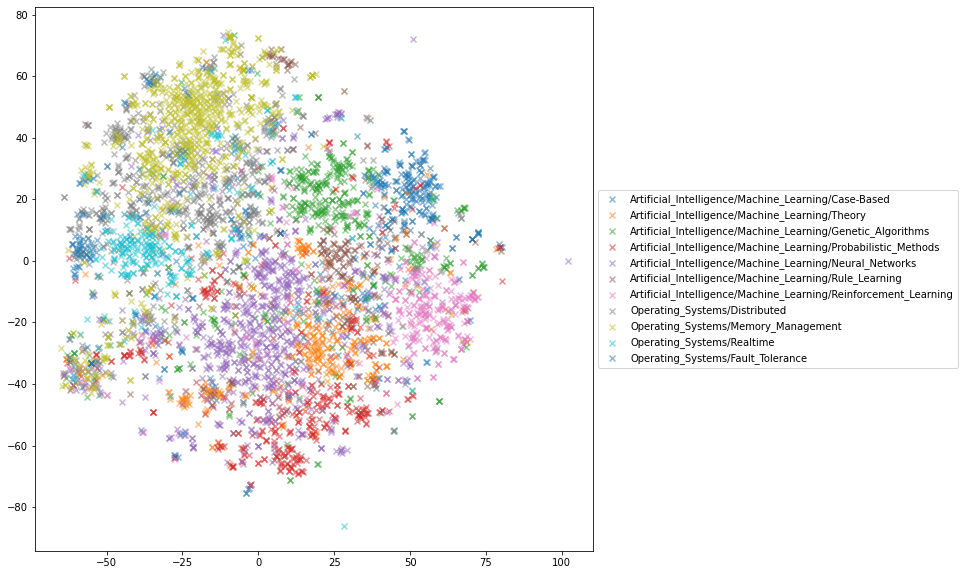

In [71]:
fix, ax = plt.subplots(figsize=(10, 10))
for idx, label in idx_to_label.items():
    
    ax.scatter(feature_emb[y == idx][:, 0], feature_emb[y == idx][:, 1], label=label, alpha=0.5, marker='x')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

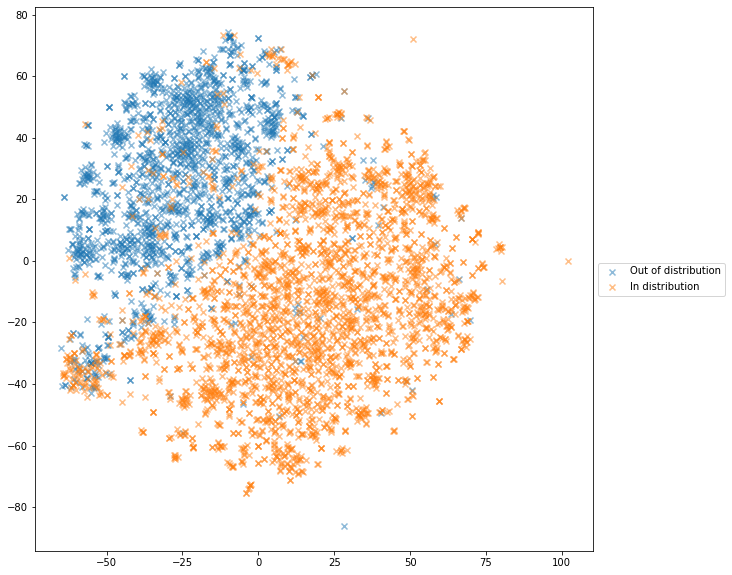

In [72]:
fix, ax = plt.subplots(figsize=(10, 10))
    
ax.scatter(feature_emb[is_ood][:, 0], feature_emb[is_ood][:, 1], label='Out of distribution', alpha=0.5, marker='x')
ax.scatter(feature_emb[~is_ood][:, 0], feature_emb[~is_ood][:, 1], label='In distribution', alpha=0.5, marker='x')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [139]:
X_diffused = A_powers['PPR-10'] @ X

In [149]:
tsne_features_diffused = TSNE(verbose=1, perplexity=5.0)
feature_emb_diffused = tsne_features_diffused.fit_transform(X_diffused)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 4553 samples in 0.022s...
[t-SNE] Computed neighbors for 4553 samples in 3.649s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4553
[t-SNE] Computed conditional probabilities for sample 2000 / 4553
[t-SNE] Computed conditional probabilities for sample 3000 / 4553
[t-SNE] Computed conditional probabilities for sample 4000 / 4553
[t-SNE] Computed conditional probabilities for sample 4553 / 4553
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.376839
[t-SNE] KL divergence after 1000 iterations: 0.554304


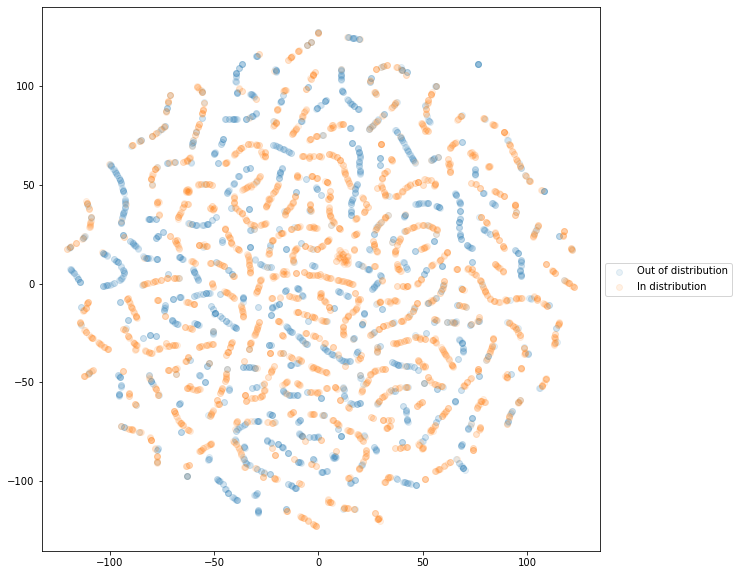

In [150]:
fix, ax = plt.subplots(figsize=(10, 10))
    
ax.scatter(feature_emb_diffused[is_ood][:, 0], feature_emb_diffused[is_ood][:, 1], label='Out of distribution', alpha=0.1, marker='o')
ax.scatter(feature_emb_diffused[~is_ood][:, 0], feature_emb_diffused[~is_ood][:, 1], label='In distribution', alpha=0.1, marker='o')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

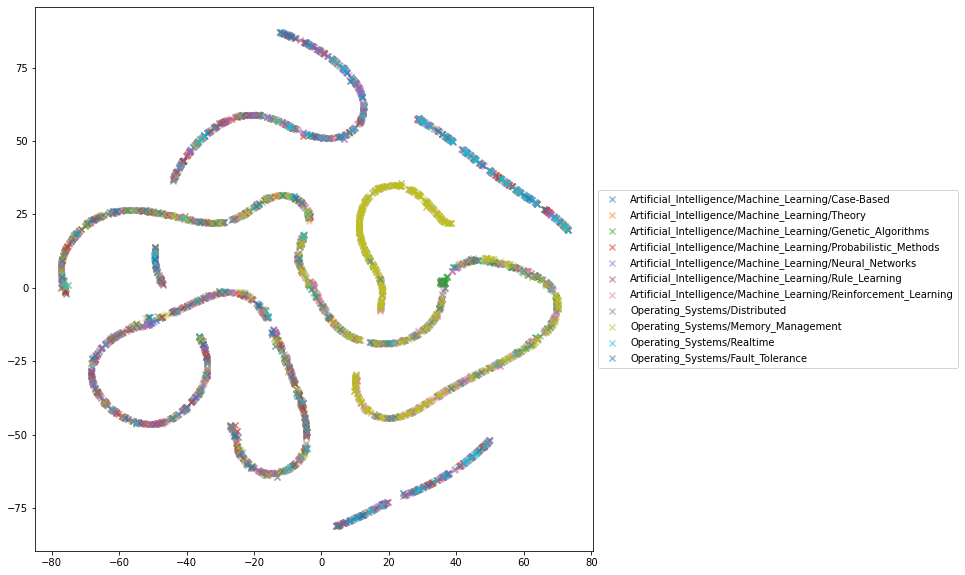

In [78]:
fix, ax = plt.subplots(figsize=(10, 10))
for idx, label in idx_to_label.items():
    
    ax.scatter(feature_emb_diffused[y == idx][:, 0], feature_emb_diffused[y == idx][:, 1], label=label, alpha=0.5, marker='x')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))